In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

In [2]:
seed = open("seeds_dataset.txt")
df = pd.read_table(seed,header=None, names=["area","perimeter","compactness","length","width","asymmetry coefficient","length of kernel groove","label"])
df.head()

,area,perimeter,compactness,length,width,asymmetry coefficient,length of kernel groove,label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
features = df.columns[:-1]
label=df["label"]
df = df[features]
features

Index(['area', 'perimeter', 'compactness', 'length', 'width',
       'asymmetry coefficient', 'length of kernel groove'],
      dtype='object')

# PCA

In [4]:
def pca(X):
    X = X-np.mean(X,axis=0)

    # compute the covariance matrix sigma
    cov = np.cov(X.T)

    # utilizing SVD decomposition, get the eigenvalues and corresponding eigenvectors
    values, vectors = np.linalg.eig(cov)

    # since K=2, the top 2 eigenvalues and corresponding eigenvectors are obtained by PCA
    # first, sort all eigenvalues in descending order according to their values
    index = np.argsort(values)[::-1]
    values = values[index]
    vectors = vectors[:,index]

    principal_component = vectors[:,:2]
    projected = X@principal_component
    return projected 

# K Means

In [5]:
import random

def k_means(X,clusters):
    number = len(X)
    numbers = random.sample(range(number),3)
    centroids = [X[i] for i in numbers]
    iterations = 0
    while (iterations<=100): #set an optional stopping criterion
        cluster = [[] for i in range(clusters)]
        for x in X:
            distance = [np.linalg.norm(x - c) for c in centroids]
            fcluster = np.argmin(distance) # find the cluster that have the minimum distance to the points they assigned
            cluster[fcluster].append(x) #assign the points to the new cluster
        
        new_centroids = []
        for j in range(clusters):
            temp = centroids[j]
            if len(cluster[j]) > 0: #if we find a cluster needs to be update, we set the new centroid to be the mean of all points assigned to the cluster
                temp = np.mean(cluster[j],axis=0)
            new_centroids.append(temp)
        iterations += 1
        if np.allclose(centroids, new_centroids): # if the updated centroids are similar to the original one, then break
            break
    centroids = new_centroids
    assignment = [np.argmin([np.linalg.norm(x-c) for c in centroids]) for x in X]
    centroids = np.array(centroids)
    return assignment, centroids

In [6]:
df_pca = pca(df.values)

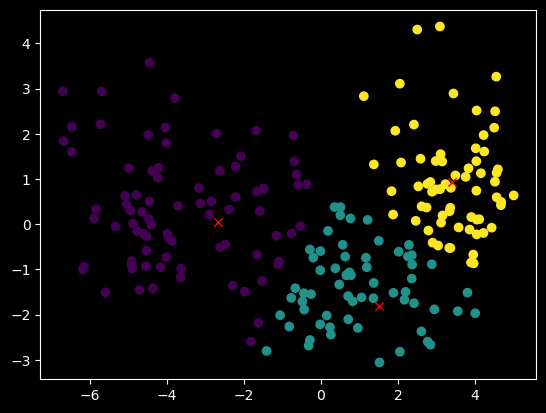

In [7]:
clusters, centroids = k_means(df_pca, 3)

plt.scatter(df_pca[:,0],df_pca[:,1],c=clusters)
plt.scatter(centroids[:,0],centroids[:,1],marker='x',linewidths=1,color='r')
plt.show()

# Pred_Assignments & Real_Assignments

In [8]:
real_assignments = label
pred_assignments = []
for _ in clusters:
    pred_assignments.append(3-_)

# Sihouette coefficient

In [9]:
def sihouette(X,label):
    distances = pairwise_distances(X) # get the pairwise distances between each two datapoints
    n_clusters = len(np.unique(label))
    labels=[x+1 for x in range(n_clusters)]
    sihouette = 0.0
    #print(distances)
    for i in range(len(X)):
        # the average value of the distance of given data point and points within the same cluster
        #print(type(label[i]))
        incluster = np.mean(distances[i,label==label[i]])
        #print(incluster)
        # the average value of the distance between the given data point and pointsd from the nearest neighboring cluster
        outcluster = np.min([np.mean(distances[i,label==labels[j]]) for j in range(n_clusters) if labels[j]!=label[i]])
        #print(outcluster)
        temp = abs(incluster-outcluster)
        if (temp!=0):
            temp = temp/max(incluster,outcluster)
        sihouette += temp

    sihouette/=len(X)
    return sihouette

In [10]:
sihouette(df_pca,np.array(pred_assignments))

0.474492078843778

In [11]:
def randind(ground,pred):
    n = len(ground)
    tp = 0
    tn = 0
    for i in range(n):
        for j in range(i+1,n):
            if ground[i]==ground[j] and pred[i]==pred[j]:
                tp +=1
            elif ground[i]!=ground[j] and pred[i]!=pred[j]:
                tn+=1
    randind = (tp+tn)/(n *(n-1)/2)
    return randind

In [12]:
randind(label,pred_assignments)

0.8713602187286398